In [22]:
import tensorflow as tf
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout
from keras.utils import to_categorical

In [23]:
try:
    data = pl.read_csv('SPAM text message 20170820 - Data.csv')
except:
    data = pl.read_csv('/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv')
finally:
    data

In [24]:
data.groupby('Category').count()

Category,count
str,u32
"""ham""",4825
"""spam""",747


In [25]:
ham_msg = data.filter(pl.col('Category') == 'ham')
spam_msg = data.filter(pl.col('Category') == 'spam')

In [26]:
#randomly taking data from ham_ msg
ham_msg = ham_msg.sample(n=len(spam_msg))

In [27]:
print(ham_msg.shape, spam_msg.shape)

(747, 2) (747, 2)


In [28]:
data

Category,Message
str,str
"""ham""","""Go until juron…"
"""ham""","""Ok lar... Joki…"
"""spam""","""Free entry in …"
"""ham""","""U dun say so e…"
"""ham""","""Nah I don't th…"
"""spam""","""FreeMsg Hey th…"
"""ham""","""Even my brothe…"
"""ham""","""As per your re…"
"""spam""","""WINNER!! As a …"


In [29]:
balanced_data = ham_msg.vstack(spam_msg)
balanced_data = balanced_data.with_columns(
    pl.when(pl.col("Category") == 'spam').then(1).otherwise(0).alias('Category')
)

In [30]:
balanced_data

Category,Message
i32,str
0,"""Ok i found dis…"
0,"""I havent lei..…"
0,"""Haha figures, …"
0,"""Hey chief, can…"
0,"""Even my brothe…"
0,"""Thx. All will …"
0,"""You intrepid d…"
0,"""Sweet heart ho…"
0,"""Hi Jon, Pete h…"


In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(
    balanced_data['Message'],
    balanced_data['Category'],
    test_size=0.2,
    random_state=42
)

In [32]:
X_train = np.array(X_train, dtype=np.chararray)
X_test = np.array(X_test, dtype=np.chararray)
X_train

array(['Printer is cool. I mean groovy. Wine is groovying',
       'Nutter. Cutter. Ctter. Cttergg. Cttargg. Ctargg. Ctagg. ie you',
       'Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?',
       ...,
       'You have an important customer service announcement from PREMIER. Call FREEPHONE 0800 542 0578 now!',
       'URGENT! Your Mobile number has been awarded with a £2000 prize GUARANTEED. Call 09061790126 from land line. Claim 3030. Valid 12hrs only 150ppm',
       'How come it takes so little time for a child who is afraid of the dark to become a teenager who wants to stay out all night?'],
      dtype=object)

In [33]:
vocab_size = 10000
sequence_length = 100

# Create the layer.
vectorized_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)

X_test = tf.expand_dims(X_test, -1) # add a new dimension
X_test = tf.squeeze(X_test, axis=1)

X_train = tf.expand_dims(X_train, -1) # add a new dimension
X_train = tf.squeeze(X_train, axis=1)

vectorized_layer.adapt(X_test)
vectorized_X_test = vectorized_layer(X_test)

vectorized_layer.adapt(X_train)
vectorized_X_train = vectorized_layer(X_train)

In [34]:
Y_train = np.array(Y_train, dtype=np.int64)
Y_test = np.array(Y_test, dtype=np.int64)

# model

In [35]:
model = tf.keras.models.Sequential(
    [
        Embedding(vocab_size + 1, 100, input_length=sequence_length),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)

In [36]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer='adam'
)

In [37]:
history = model.fit(
    vectorized_X_train,
    Y_train,
    epochs=50,
    validation_split=0.2,
)

Epoch 1/50


C:\Users\moham\anaconda3\lib\site-packages\keras\src\backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 3s 38ms/step - loss: 0.5172 - accuracy: 0.7490 - val_loss: 0.4102 - val_accuracy: 0.8285
Epoch 2/50
30/30 [==============================] - 1s 30ms/step - loss: 0.2640 - accuracy: 0.9038 - val_loss: 0.2310 - val_accuracy: 0.9121
Epoch 3/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0961 - accuracy: 0.9759 - val_loss: 0.2122 - val_accuracy: 0.9121
Epoch 4/50
30/30 [==============================] - 1s 29ms/step - loss: 0.0399 - accuracy: 0.9927 - val_loss: 0.2144 - val_accuracy: 0.9247
Epoch 5/50
30/30 [==============================] - 1s 32ms/step - loss: 0.0160 - accuracy: 0.9948 - val_loss: 0.1698 - val_accuracy: 0.9331
Epoch 6/50
30/30 [==============================] - 1s 31ms/step - loss: 0.0054 - accuracy: 0.9990 - val_loss: 0.1871 - val_accuracy: 0.9372
Epoch 7/50
30/30 [==============================] - 1s 30ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1824 - val_accuracy: 0.9372
Epoch 8/50
30/30 [======

In [38]:
model.evaluate(
    vectorized_X_test,
    Y_test
)

10/10 [==============================] - 0s 4ms/step - loss: 1.4281 - accuracy: 0.7291


[1.4281102418899536, 0.7290970087051392]

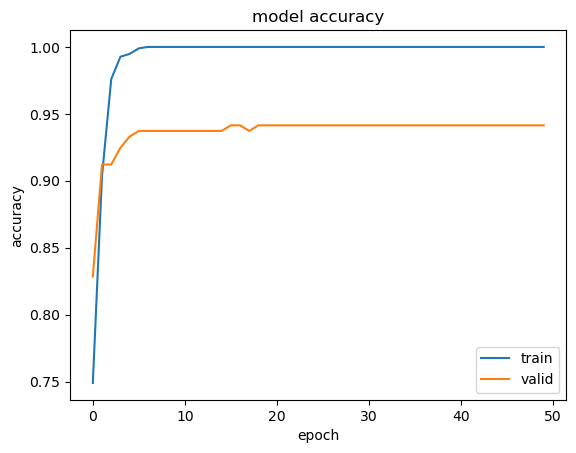

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

In [40]:
predict_msg = [
    "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
    "Ok lar... Joking wif u oni...",
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [41]:
vectorized_layer.adapt(predict_msg)
vectorized_predict_msg = vectorized_layer(predict_msg)
model.predict(vectorized_predict_msg)

1/1 [==============================] - 0s 108ms/step


array([[0.999585  ],
       [0.06891108],
       [0.21795009]], dtype=float32)